# 1000 Genomes analysis on BigQuery

Authors: Prathima Vembu <br>
Notebook kernel: R (https://irkernel.github.io/installation/)<br>
Recommended Google Cloud Platform machine type: n1-standard-1 <br>
Predicted runtime: ~8 minutes <br>
Predicted cost for analysis <br>
1. Variant optimized table : 83.40 USD per one month <br>
2. Sample optimized table : 0.00 USD per one month first 
*Note: 1 TB of query data processed per month is free* <br>

This notebook includes methods for reproducing several figures in the 1000 Genomes phase 3 publication (https://doi.org/10.1038/nature15393)<br>

#### Variant optimized vs sample optimized tables 
|Feature|Variant optimized|Sample optimized|
|---|---|---|
|User specified |No, generated by default|Yes, use ```--sample_lookup_optimized_output_table``` parameter|
|Number of tables created |25 (23 chromosome, sample_info, residual_info)|25 (23 chromosome, sample_info, residual_info)|
|Question answered|Variant lookup query - Find all variants in a given genomic region|Sample lookup query - Find all variants in Sample 'A'|
|Storage cost|No additional storage cost|Additional storage cost (for 25 tables), recovered when running queries for sample lookup analysis|
|Call field|Call column not flattened/unested |Call column flattened/unested|
|New field|No new column added|New column sample_id added which has the same value as ```call.sample_id``` column|
|1000 Genomes table size|1000_genomes_phase_3_variants_20150220 - 5.38 TB|1000_genomes_phase_3_optimized_schema_variants_20150220 - 1.94 TB|



#### Table location 
Variant optimized table : ```bigquery-public-data.human_genome_variants.1000_genomes_phase_3_variants_20150220``` <br>
Sample optimized table : ```bigquery-public-data.human_genome_variants.1000_genomes_phase_3_optimized_schema_variants_20150220```


#### Query cost comparison 

| Analysis | Variant table(1000Genomes variant table)| Data processed | Sample table(1000Genomes sample optimized table) | Data processed |
|---|---|---|---|---|
|Distinct sample_id’s|3.70 USD |1.74 TB|0.00 USD|0.092 TB|
|Number of mapped and missing ID’s|3.70 USD|1.74 TB|0.00 USD|0.092 TB|
|Number of variant sites per sample| 19.00 USD|4.8 TB|0.00 USD|0.255 TB|
|Average singletons|19.00 USD|4.8 TB|0.00 USD|0.256 TB|
|Average singletons and rare variants |19.00 USD|4.8 TB|0.00 USD|0.256 TB|
|Distribution of Allele Frequency|0.00 USD|0.001 TB|0.00 USD|0.001 TB|
|Z-score computation|19.00 USD|4.8 TB|0.00 USD|0.255 TB|
|Total|83.4 USD|22.68 TB|0.00 USD|1.207 TB|


Before starting the analysis install and load the below packages 

In [76]:
#helps connecting R to DBMS
install.packages("DBI") 
#helps to work with data on cloud storage
install.packages("bigrquery") 
#package to perform multiple data manipulation functions
install.packages("pillar")
#package to restructure and aggregate dataframes
install.packages("reshape2") 
#package for creating graphics 
install.packages("ggplot2") 

library(DBI)
library(bigrquery)
library(pillar)
library(reshape2)
library(ggplot2)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



### Authenticate and connect to BigQuery 
Connect to the Google BigQuery database account using ```dbconnect```. Replace ```BILLING_ACCOUNT``` with the name of the Google Cloud project you want charges to be billed to.

In [79]:
#dbconnect creates a connection to the DBMS
gcp_account<-dbConnect(bigquery(),"bigquery-public-data", 
                       dataset="human_genome_variants", 
                       billing = "gbsc-gcp-project-mvp-dev")

### Introductory analysis
Check to confirm the number of samples present in the BigQuery table (from the paper, n=2504). <br>
Two tables are available for the 1000 Genomes project which can be found under *bigquery-public-data.human_genome_variants* <br>
1. 1000_genomes_phase_3_variants_20150220 : The Variant table<br>
2. 1000_genomes_sample_info : The Sample table


In [80]:
#Number of samples in the Variant table - queries 1.74 TB
variant_sample_count_sql<-"SELECT
COUNT(distinct call.name) AS Sample_count
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_variants_20150220`v, UNNEST(v.call) AS call"

variant_sample_count<-dbGetQuery(gcp_account,variant_sample_count_sql)
variant_sample_count

Auto-refreshing stale OAuth token.



Sample_count
<int>
2504


In [46]:
#Optimized table - queries 94.27 GB data
variant_optimized_sample_count_sql<-"SELECT
COUNT(distinct call.name) AS Sample_count
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_optimized_schema_variants_20150220`v, UNNEST(v.call) AS call"

variant_optimized_sample_count<-dbGetQuery(gcp_account,variant_optimized_sample_count_sql)
variant_optimized_sample_count

Sample_count
<int>
2504


In [25]:
#Number of samples in the Sample table 
sample_table_count_sql<-"SELECT
COUNT(Sample) AS Sample_count
FROM `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`"

sample_table_count<-dbGetQuery(gcp_account, sample_table_count_sql)
sample_table_count

Sample_count
<int>
3500


In [48]:
#Compute the number of mapped ID's and the number of missing ID's - queries 1.74Tb 
mapped_missing_values_sql<-"WITH cte1 AS (
SELECT DISTINCT call.name AS call_name
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_variants_20150220`v,UNNEST(v.call) AS call
), cte2 AS (SELECT distinct Sample AS sample_name 
 FROM `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`
),cte3 AS(SELECT call_name, sample_name 
  FROM cte1 
  RIGHT JOIN cte2 
  ON cte1.call_name=cte2.sample_name
)
SELECT SUM(CASE WHEN call_name IS NULL THEN 1 ELSE 0 END) AS missing_values, 
SUM(CASE WHEN call_name IS NOT NULL THEN 1 ELSE 0 END) AS mapped_values FROM cte3"

mapped_missing_values<-dbGetQuery(gcp_account, mapped_missing_values_sql)
mapped_missing_values

missing_values,mapped_values
<int>,<int>
996,2504


Given that both these tables have different number of distinct sample ID's, it is important to make sure that the list of sample ID's in the variant table is a subset of the ID's from the sample table to prevent data loss. The query below computes the number of mapped ID's and number of missing ID's

In [49]:
#OPTIMIZED TABLE - queries 94.27 GB 
mapped_optimized_missing_values_sql<-"WITH cte1 AS (
SELECT DISTINCT call.name AS call_name
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_optimized_schema_variants_20150220`v,UNNEST(v.call) AS call
), cte2 AS (SELECT distinct Sample AS sample_name 
 FROM `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`
),cte3 AS(SELECT call_name, sample_name 
  FROM cte1 
  RIGHT JOIN cte2 
  ON cte1.call_name=cte2.sample_name
)
SELECT SUM(CASE WHEN call_name IS NULL THEN 1 ELSE 0 END) AS missing_values, 
SUM(CASE WHEN call_name IS NOT NULL THEN 1 ELSE 0 END) AS mapped_values FROM cte3"

mapped_optimized_missing_values<-dbGetQuery(gcp_account, mapped_optimized_missing_values_sql)
mapped_optimized_missing_values


missing_values,mapped_values
<int>,<int>
996,2504


#### 1.1: Number of variant sites per genome 
Refer: [Figure 1b](https://www.nature.com/articles/nature15393/figures/1)

In [27]:
#Compute the number of variant sites per genome - queries 4.8 TB
variant_sites_per_genome_sql<-"SELECT s.Population,s.Sample,COUNT(reference_name) as variant_count,
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_variants_20150220`v, UNNEST(v.call) AS call
INNER JOIN `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`s
ON call.name=s.Sample
WHERE EXISTS (SELECT gt FROM UNNEST(call.genotype) gt WHERE gt > 0 AND reference_name NOT IN ('X','Y','MT'))
GROUP BY 1,2 ORDER BY variant_count DESC"

variant_sites_per_genome<-dbGetQuery(gcp_account, variant_sites_per_genome_sql)
head(variant_sites_per_genome)

Population,Sample,variant_count
<chr>,<chr>,<int>
MSL,HG03096,5047803
MSL,HG03052,5044744
MSL,HG03445,5044673
MSL,HG03066,5040476
MSL,HG03085,5039585
MSL,HG03097,5039247


In [50]:
#OPTIMIZED TABLE - queries 261.17 GB
variant_sites_per_genome_optimized_sql<-"SELECT s.Population,s.Sample,COUNT(reference_name) as variant_count,
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_optimized_schema_variants_20150220`v, UNNEST(v.call) AS call
INNER JOIN `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`s
ON call.name=s.Sample
WHERE EXISTS (SELECT gt FROM UNNEST(call.genotype) gt WHERE gt > 0 AND reference_name NOT IN ('X','Y','MT'))
GROUP BY 1,2 ORDER BY variant_count DESC"

variant_sites_per_optimized_genome<-dbGetQuery(gcp_account, variant_sites_per_genome_optimized_sql)
head(variant_sites_per_optimized_genome)

Auto-refreshing stale OAuth token.



Population,Sample,variant_count
<chr>,<chr>,<int>
MSL,HG03096,5047803
MSL,HG03052,5044744
MSL,HG03445,5044673
MSL,HG03066,5040476
MSL,HG03085,5039585
MSL,HG03097,5039247


In [28]:
#Set the order of the labels 
variant_sites_per_genome$Population<-factor(variant_sites_per_genome$Population,
                                            levels = unique(variant_sites_per_genome$Population))


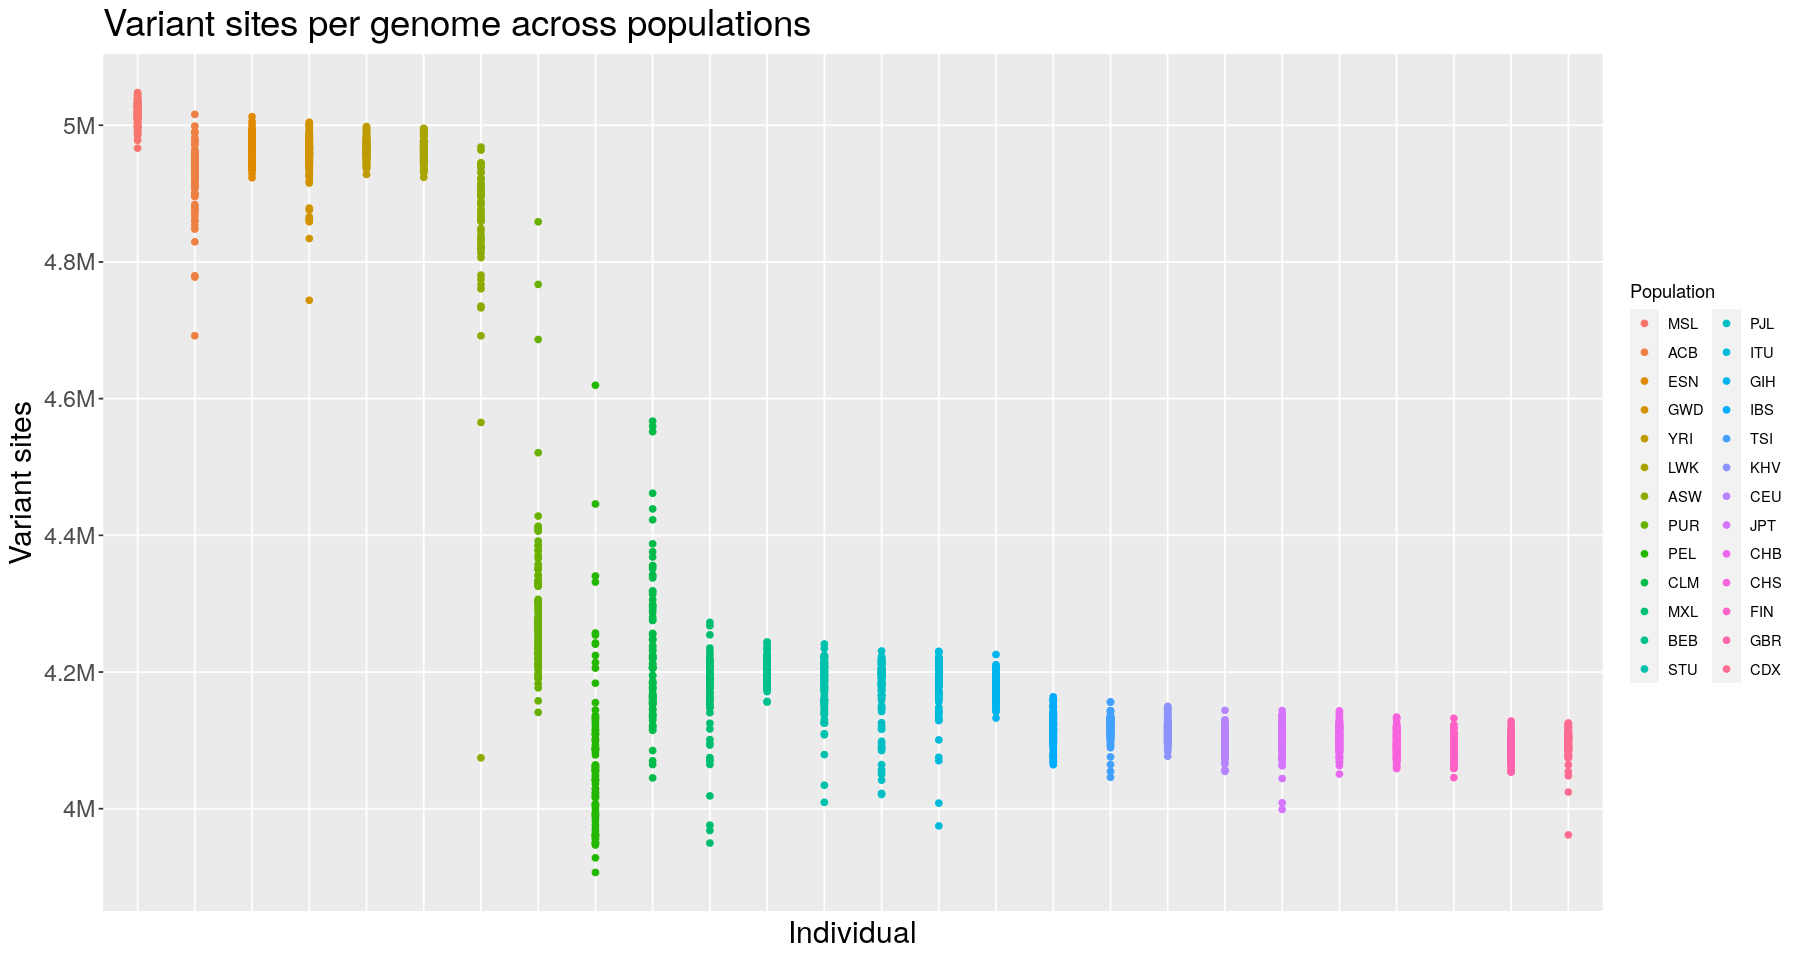

In [29]:
#Make plots wider on jupyter notebooks
options(repr.plot.width=15, repr.plot.height=8)

#Generate the plot
ggplot(variant_sites_per_genome, aes(y=variant_count,x=Population, color=Population))+
geom_point()+theme(axis.texet.x = element_blank(),axis.ticks.x = element_blank())+
scale_y_continuous(breaks = c(3800000,4000000,4200000,4400000,4600000,4800000,5000000,5200000,5400000,5600000),
                   minor_breaks = NULL, labels = function(l) {paste0(round(l/1e6,1),"M")})+
labs(title = "Variant sites per genome across populations",x = "Individual",y = "Variant sites")+
theme(plot.title = element_text(size=22),axis.text=element_text(size=14),axis.title=element_text(size=18))


#### 1.2: The average number of singletons per genome
Refer: [Figure 1c](https://www.nature.com/articles/nature15393/figures/1)


In [30]:
#Compute the number of singletons per genome
singletons_per_genome_sql<-"WITH cte1 AS (SELECT s.Population,Sample,
COUNT(reference_name) as variant_sites,COUNTIF(AC=1) AS Singletons,
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_variants_20150220`v,
UNNEST(v.alternate_bases) AS Alternate, UNNEST(v.call) AS call
INNER JOIN `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`s
ON call.name=s.Sample
WHERE EXISTS(SELECT gt FROM UNNEST(call.genotype) gt WHERE gt>0 ) AND reference_name NOT IN ('X','Y','MT')
GROUP BY 1,2)
SELECT Population, AVG(Singletons) AS Average_Singletons FROM cte1 GROUP BY 1 ORDER BY 2 DESC"

singletons_per_genome<-dbGetQuery(gcp_account, singletons_per_genome_sql)
head(singletons_per_genome)


Population,Average_Singletons
<chr>,<dbl>
LWK,20928.76
GWD,18245.86
BEB,17653.98
MSL,17013.59
CHB,16763.60
KHV,16590.04


The output table is sorted in a descending order by the "Average_Singletons" column. Output dataframe has 2 columns, the sub-population group and the average singletons computed.

In [31]:
#Setting the labels, AC=1
singletons_per_genome$Population<-factor(singletons_per_genome$Population,
                                         levels = unique(singletons_per_genome$Population))


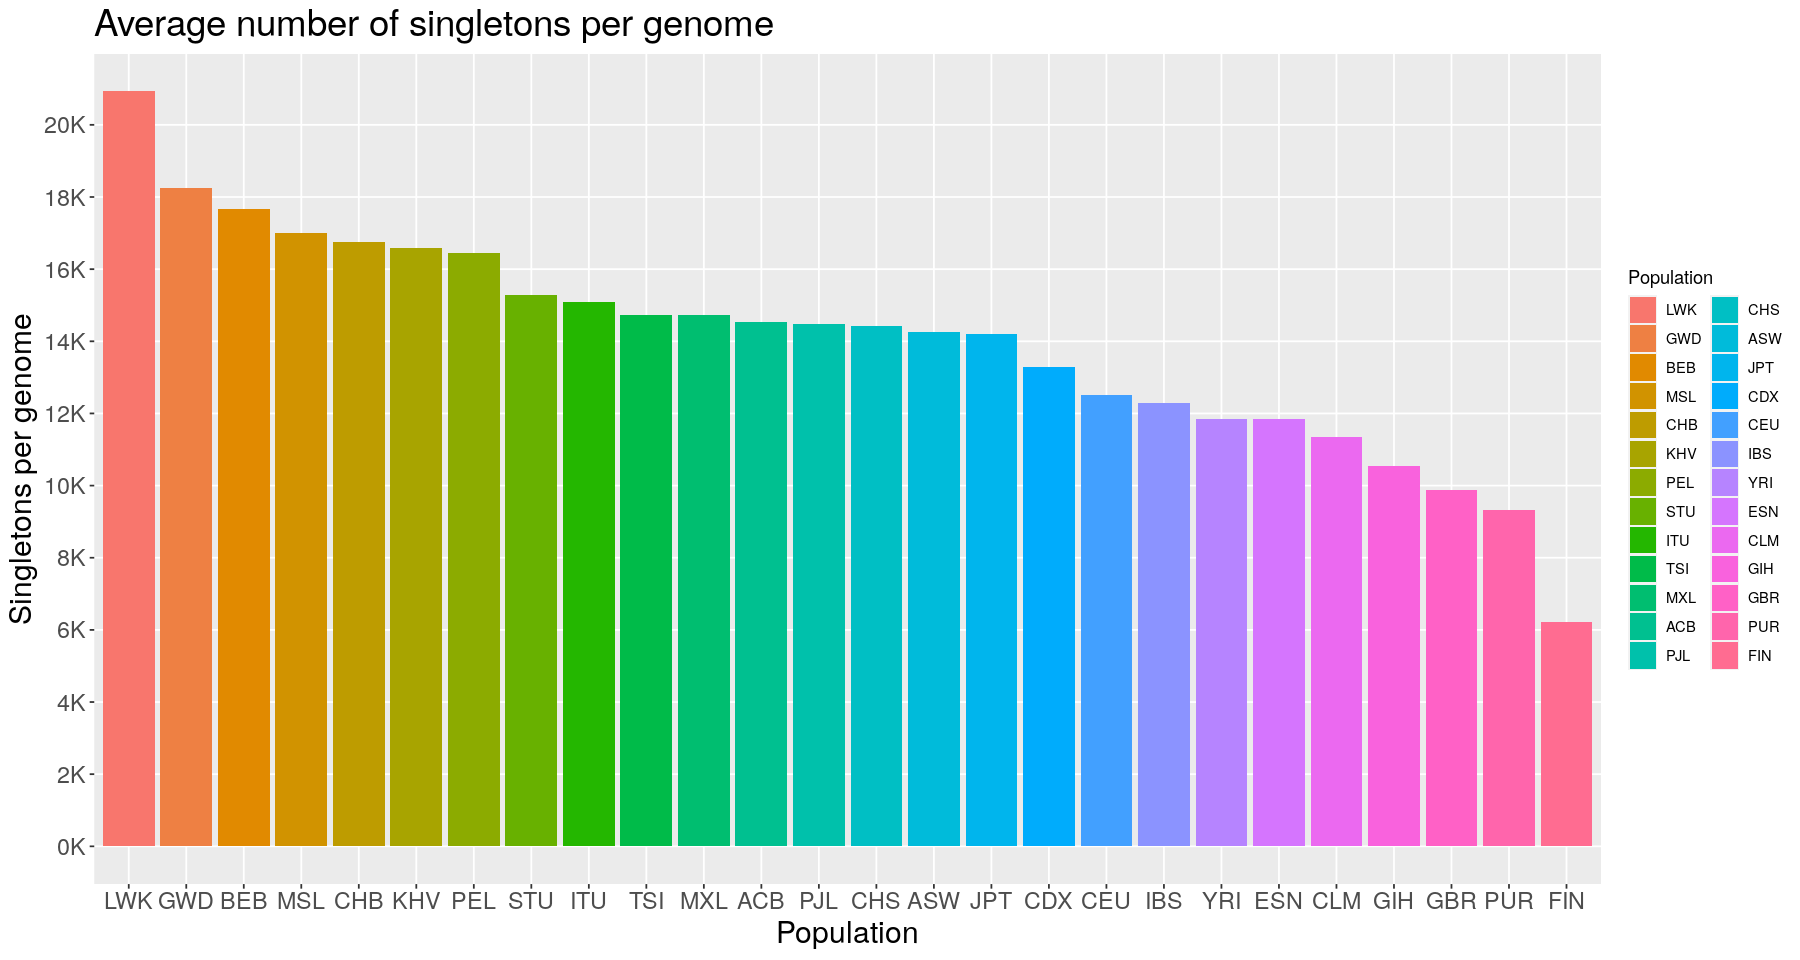

In [32]:
#Make plots wider on jupyter notebooks
options(repr.plot.width=15, repr.plot.height=8)

#Generate the plot, AC=1
ggplot(singletons_per_genome,aes(y=Average_Singletons,x=Population))+
geom_bar(aes(fill=Population),stat = "identity",position="dodge")+
scale_y_continuous(breaks = c(0,2000,4000,6000,8000,10000,12000,14000,16000,18000,20000,22000),
                   minor_breaks = NULL, labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Average number of singletons per genome",x = "Population",y = "Singletons per genome")+
theme(plot.title = element_text(size=22),axis.text=element_text(size=14),axis.title=element_text(size=18))



#### 1.3: Allele frequency - range 
Refer: Extended Figure 3a


In [69]:
#Extracting the allele frequency
af_sql<-"SELECT COUNT(AF) AF_Count, AF_bucket, 
FROM (SELECT  AF, CASE WHEN AF>=0 AND AF<=0.1 THEN 1
                       WHEN AF>0.1 AND AF<=0.2 THEN 2
                       WHEN AF>0.2 AND AF<=0.3 THEN 3
                       WHEN AF>0.3 AND AF<=0.4 THEN 4
                       WHEN AF>0.4 AND AF<=0.5 THEN 5
                       WHEN AF>0.5 AND AF<=0.6 THEN 6
                       WHEN AF>0.6 AND AF<=0.7 THEN 7
                       WHEN AF>0.7 AND AF<=0.8 THEN 8
                       WHEN AF>0.8 AND AF<=0.9 THEN 9
                       WHEN AF>0.9 AND AF<=1.0 THEN 10
                       ELSE -1 END AS AF_bucket
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_variants_20150220`v,UNNEST(v.alternate_bases) AS Alternate )
GROUP BY AF_bucket
ORDER BY AF_bucket"

af<-dbGetQuery(gcp_account, af_sql)
af

AF_Count,AF_bucket
<int>,<int>
78456666,1
1851719,2
1189519,3
882604,4
694755,5
564059,6
469664,7
396120,8
331607,9


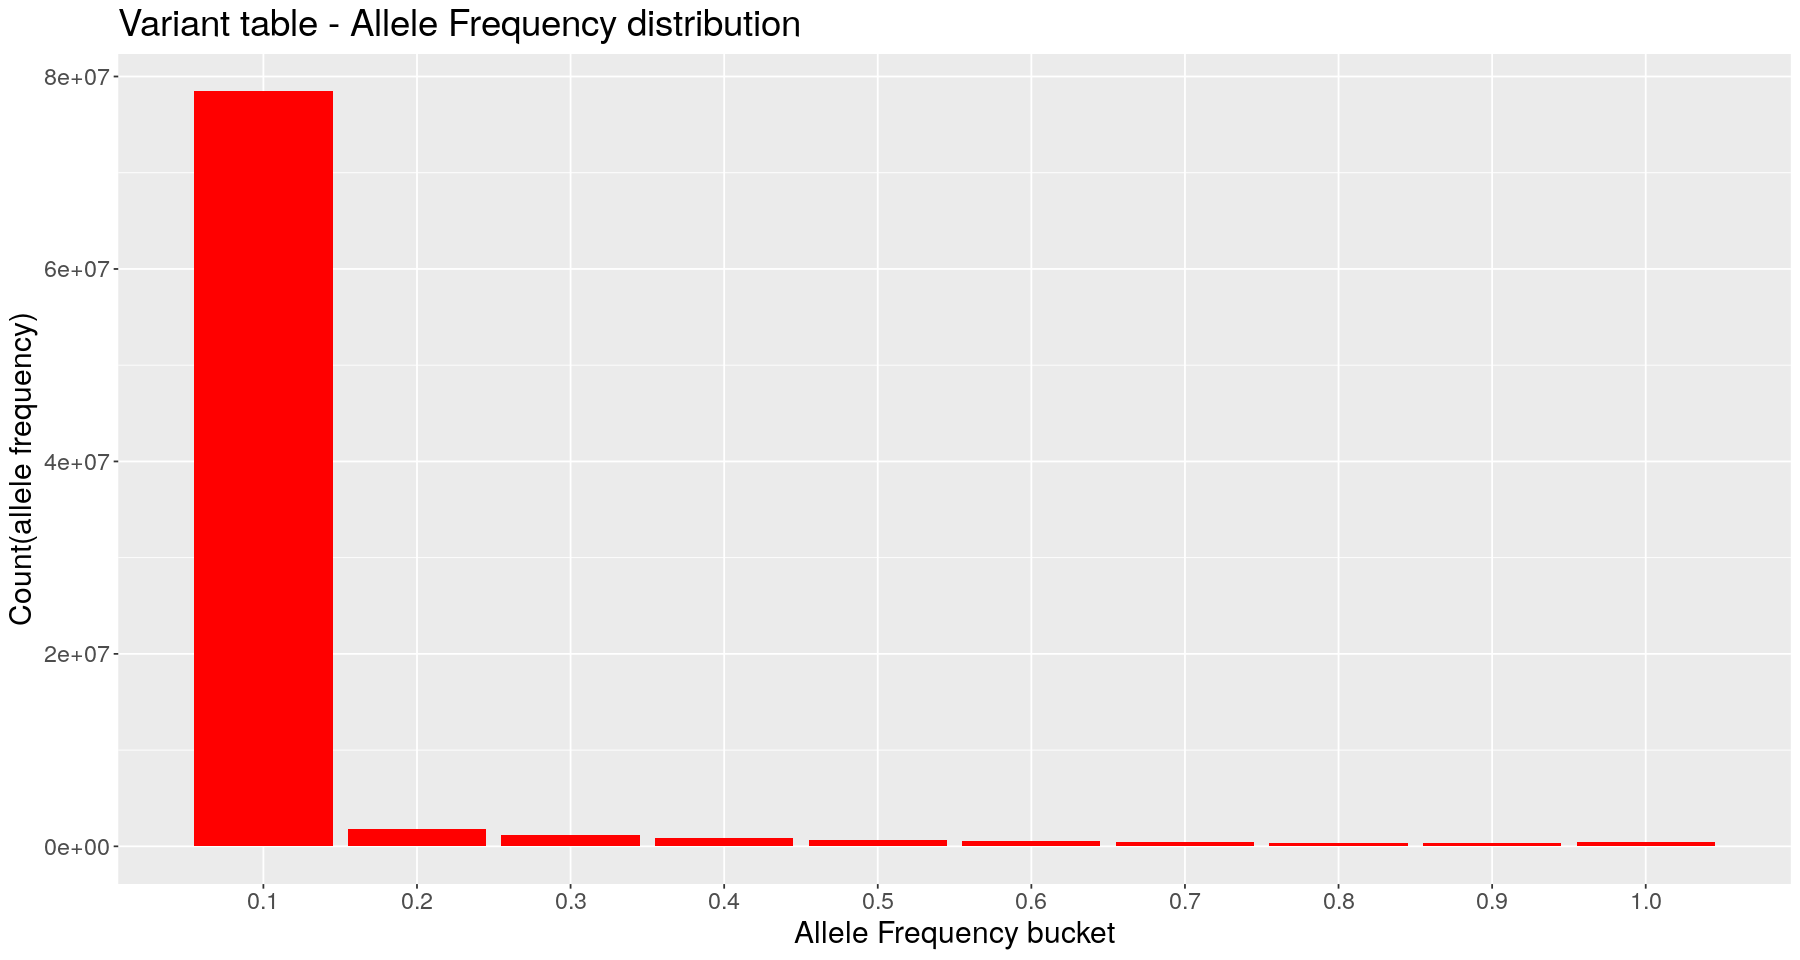

In [74]:
#Make plots wider on jupyter notebooks
options(repr.plot.width=15, repr.plot.height=8)

#Generating the graph for variant tables 
ggplot(af, aes(x=AF_bucket, y=AF_Count))+
geom_bar(stat = "identity",fill="red")+
labs(title = "Variant table - Allele Frequency distribution",x = "Allele Frequency bucket",y = "Count(allele frequency)")+
theme(plot.title = element_text(size=22),axis.text=element_text(size=14),axis.title=element_text(size=18), 
      legend.title = element_blank(),legend.text = element_blank())+
scale_x_continuous(breaks=c(1,2,3,4,5,6,7,8,9,10), minor_breaks=NULL,labels=c("0.1", "0.2", "0.3", "0.4", "0.5","0.6","0.7","0.8","0.9","1.0"))


#### 1.4: Number of rare variants and singletons per genome <br>
Refer: [Extended Figure 3b](https://www.nature.com/articles/nature15393/figures/7)


In [35]:
#Compute the number of rare variants and singletons per genome
rare_var_and_singletons_per_genome_sql<-"WITH cte1 AS (SELECT Population,Sample,
COUNT(reference_name) as variant_sites,
COUNTIF(AF<0.005) AS Rare_Variants,
COUNTIF(AC=1) AS Singletons,
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_variants_20150220`v,
UNNEST(v.alternate_bases) AS Alternate, UNNEST(v.call) AS call
INNER JOIN `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`s
ON call.name=s.Sample
WHERE EXISTS(SELECT gt FROM UNNEST(call.genotype) gt WHERE gt>0 ) AND reference_name NOT IN ('X','Y','MT')
GROUP BY 1,2) SELECT Population, AVG(Rare_variants) AS Average_rare_variants, AVG(Singletons) AS Average_singletons 
FROM cte1 GROUP BY 1 ORDER BY Average_rare_variants,Average_singletons DESC"

rare_var_and_singletons_per_genome<-dbGetQuery(gcp_account, rare_var_and_singletons_per_genome_sql)
head(rare_var_and_singletons_per_genome)


Population,Average_rare_variants,Average_singletons
<chr>,<dbl>,<dbl>
PEL,76073.94,16436.824
FIN,81428.82,6205.343
GBR,82907.99,9886.571
MXL,84285.62,14717.297
CEU,86872.90,12503.071
IBS,86990.52,12288.243


The output table contains 3 colums, the sub-population, average rare variants computed and the avaerage singletons computed. All 3 columns were used to generate the plot shown. 

In [36]:
#Set the order of the labels 
rare_var_and_singletons_per_genome$Population<-factor(rare_var_and_singletons_per_genome$Population,
                                                      levels = unique(rare_var_and_singletons_per_genome$Population))


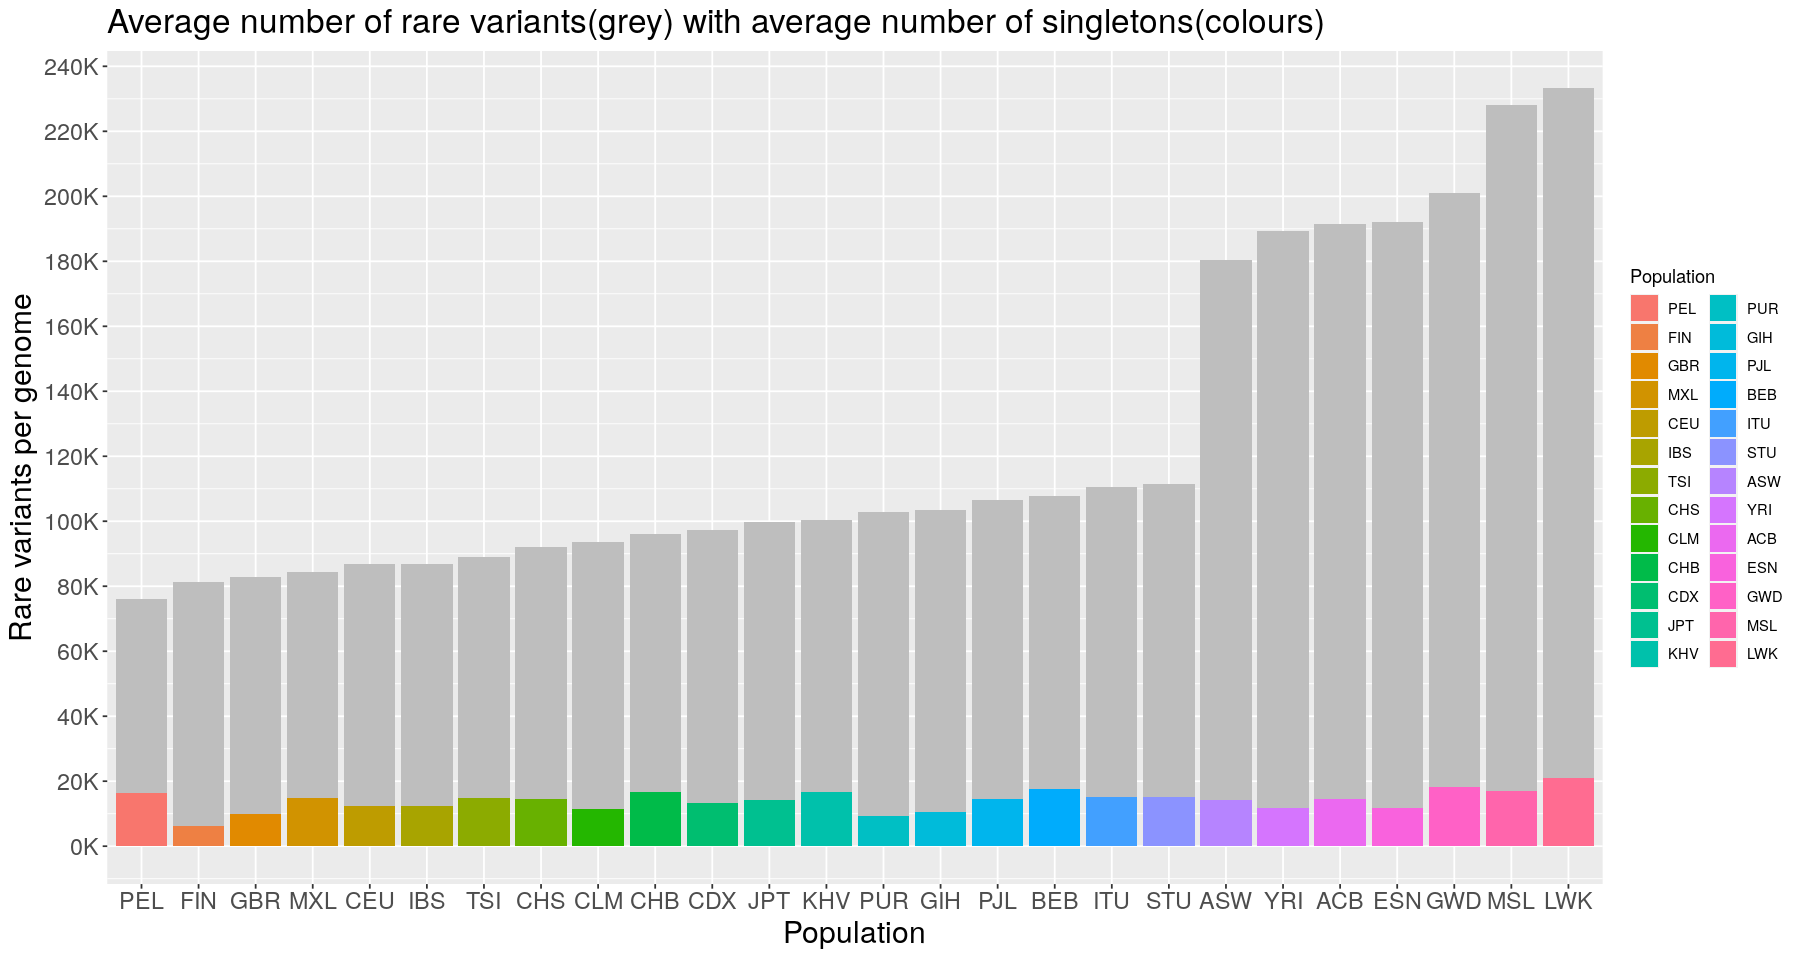

In [37]:
#Make plots wider on jupyter notebooks
options(repr.plot.width=15, repr.plot.height=8)

#Generating the graph 
ggplot(rare_var_and_singletons_per_genome,aes(x=Population, y=Average_rare_variants))+
geom_bar(stat = "identity", position = "stack", fill="grey")+
geom_bar(data = subset(rare_var_and_singletons_per_genome,variable=Average_singletons),
         aes(x=Population, y=Average_singletons, fill=Population),stat = "identity")+
scale_y_continuous(breaks = c(0,20000,40000,60000,80000,100000,120000,140000,160000,180000,200000,220000,
                              240000,260000,280000),labels = function(l) {paste0(round(l/1e3,1),"K")})+
labs(title = "Average number of rare variants(grey) with average number of singletons(colours)",
     y = "Rare variants per genome")+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18))


#### 1.5: Computing the z score for variant count for each population
The z score will tell you how far a data point is from the mean. <br>
Z score was computed using the formula: 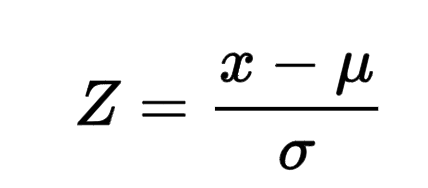

Where:<br>
Z - standard score <br>
X - Observed value <br>
μ - Mean variant site count of all genomes (across populations included)<br>
𝝈 - Standard deviation computed across all genomes (all populations included)<br>

Refer: [Extended Figure 4](https://www.nature.com/articles/nature15393/figures/8)

In [38]:
#Compute number of variant sites per genome 
z_score_sql<-"WITH cte1 AS (SELECT Population,Sample,
COUNT(reference_name) as variant_site,
FROM `bigquery-public-data.human_genome_variants.1000_genomes_phase_3_variants_20150220`v,UNNEST(v.alternate_bases) AS Alternate, 
UNNEST(v.call) AS call
INNER JOIN `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`s
ON call.name=s.Sample
WHERE EXISTS(SELECT gt FROM UNNEST(call.genotype) gt WHERE gt>0 ) AND reference_name NOT IN ('X','Y','MT')
GROUP BY 1,2), cte2 AS (SELECT AVG(variant_site) AS total_mean, STDDEV(variant_site) AS total_sd FROM cte1), 
cte3 AS (SELECT Population, AVG(variant_site) AS sub_population_mean FROM cte1 GROUP BY 1) 
SELECT Population, (sub_population_mean-total_mean)/total_sd AS Z_score FROM cte2 join cte3 on 1=1 
GROUP BY 1,2 ORDER BY Z_score DESC"

z_score<-dbGetQuery(gcp_account, z_score_sql)
z_score

Population,Z_score
<chr>,<dbl>
MSL,1.8098022
ESN,1.6782207
YRI,1.6647622
LWK,1.6609586
GWD,1.6392887
ACB,1.5574219
ASW,1.3569292
PUR,-0.1686472
CLM,-0.3511233


For the computation of the z score, the query has been broken into 4 sections:<br>
- Subquery 1: Join the variant and sample table based on sample id <br>
- Subquery 2: Compute the population mean and standard deviation across all samples (and sub-population groups)<br>
- Subquery 3: Compute the sample mean across variant sites per sub-population group <br>
- Finally, calulate the z score using the formula <br>

The output dataframe has 2 colums, the sub-population and the z-score calculated and will be used as the input dataframe to generate the below graph.  


In [39]:
#Set the order of the labels 
z_score$Population<-factor(z_score$Population, levels = unique(z_score$Population))


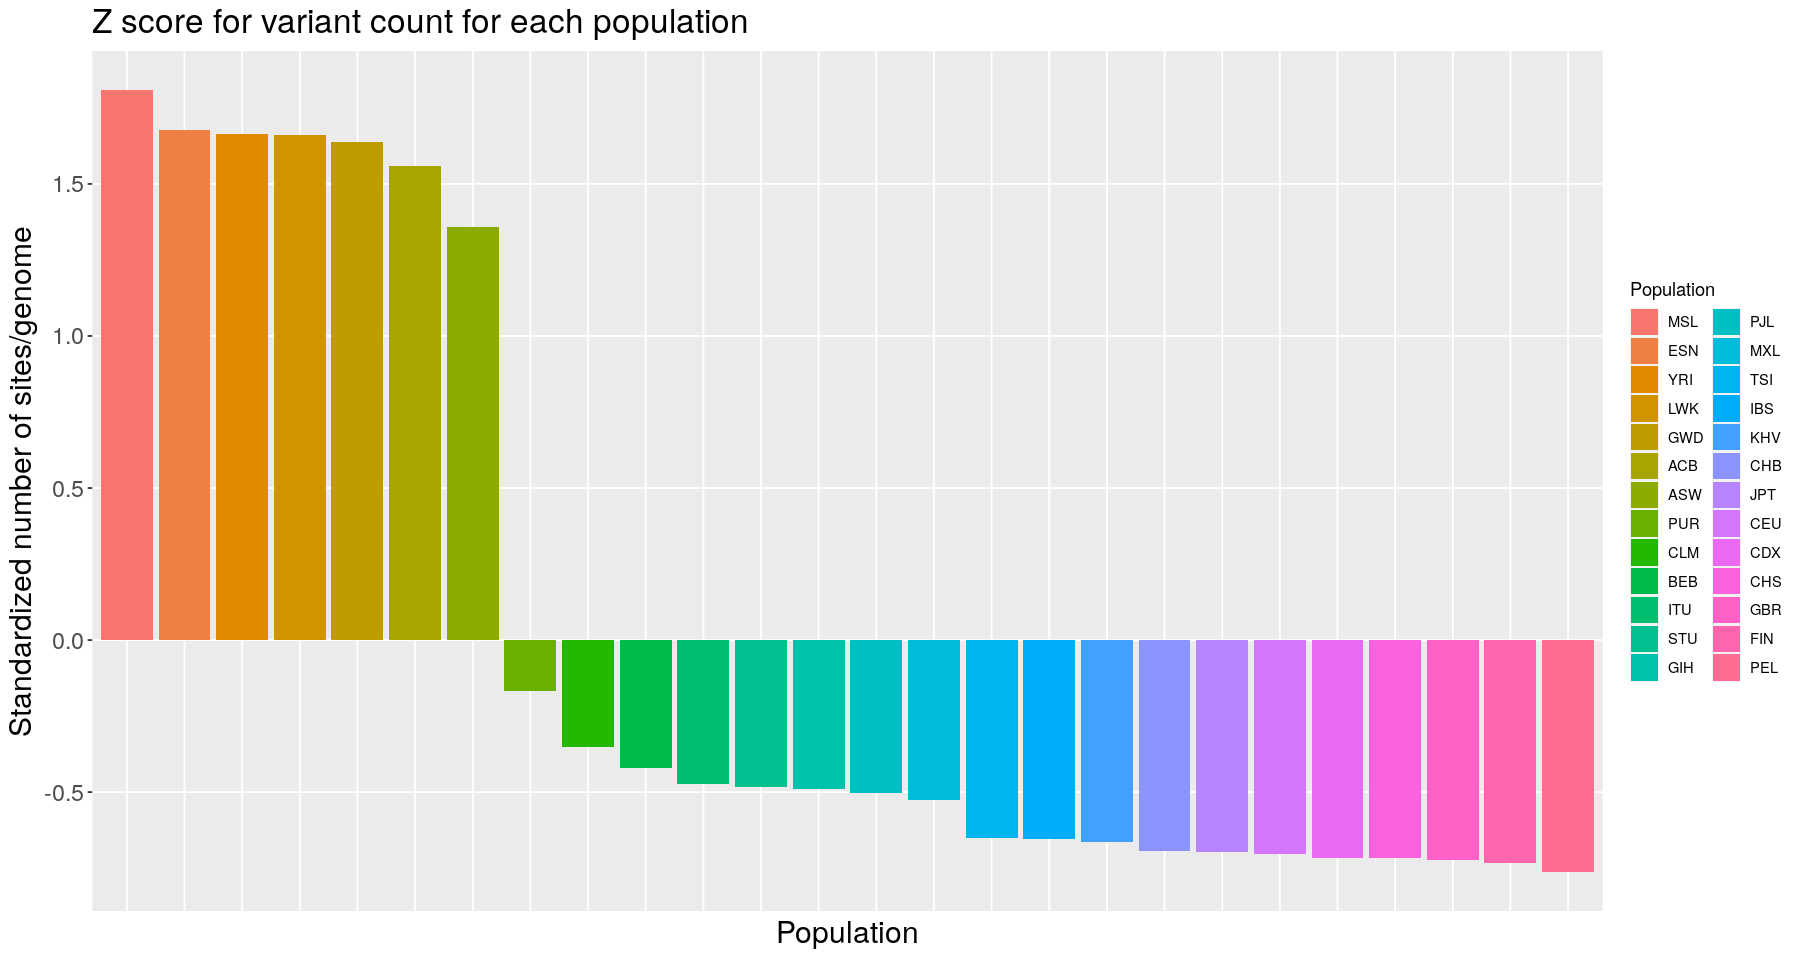

In [40]:
#Generating the graph 
ggplot(z_score, aes(y=Z_score,x=Population))+
geom_bar(aes(fill=Population), stat = "identity", position = "dodge")+
theme(axis.text.x = element_blank(),axis.ticks.x = element_blank())+
scale_y_continuous(breaks = c(-2.0,-1.5,-1.0,-0.5,0,0.5,1.0,1.5,2.0),minor_breaks = NULL)+
labs(title = "Z score for variant count for each population",y = "Standardized number of sites/genome")+
theme(plot.title = element_text(size=20),axis.text=element_text(size=14),axis.title=element_text(size=18))
